In [5]:
%ls -lat /tmp

total 804660
drwxrwxrwt 131 root     root       36864 Aug 19 10:44 ./
-rw-r--r--   1 plapp    tumuser 47452108 Aug 19 10:44 semisup_mnist-28500.meta
-rw-r--r--   1 plapp    tumuser      325 Aug 19 10:44 checkpoint
-rw-r--r--   1 plapp    tumuser  3482460 Aug 19 10:44 semisup_mnist-28500.data-00000-of-00001
-rw-r--r--   1 plapp    tumuser     1439 Aug 19 10:44 semisup_mnist-28500.index
-rw-r--r--   1 plapp    tumuser 47452108 Aug 19 10:44 semisup_mnist-28000.meta
-rw-r--r--   1 plapp    tumuser  3482460 Aug 19 10:44 semisup_mnist-28000.data-00000-of-00001
-rw-r--r--   1 plapp    tumuser     1439 Aug 19 10:44 semisup_mnist-28000.index
-rw-r--r--   1 plapp    tumuser 47452108 Aug 19 10:44 semisup_mnist-27500.meta
-rw-r--r--   1 plapp    tumuser  3482460 Aug 19 10:44 semisup_mnist-27500.data-00000-of-00001
-rw-r--r--   1 plapp    tumuser     1439 Aug 19 10:44 semisup_mnist-27500.index
-rw-r--r--   1 plapp    tumuser 47452108 Aug 19 10:44 semisup_mnist-27100.meta
-rw-r--r--   1 plapp    tum

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import semisup

from tensorflow.python.platform import app
from tensorflow.python.platform import flags

FLAGS = flags.FLAGS

flags.DEFINE_integer('sup_per_class', 2,
                     'Number of labeled samples used per class.')

flags.DEFINE_integer('sup_seed', -1,
                     'Integer random seed used for labeled set selection.')

flags.DEFINE_integer('sup_per_batch', 2,
                     'Number of labeled samples per class per batch.')

flags.DEFINE_integer('unsup_batch_size', 100,
                     'Number of unlabeled samples per batch.')

flags.DEFINE_integer('eval_interval', 500,
                     'Number of steps between evaluations.')

flags.DEFINE_float('learning_rate', 1e-3, 'Initial learning rate.')

flags.DEFINE_float('decay_factor', 0.33, 'Learning rate decay factor.')

flags.DEFINE_float('decay_steps', 5000,
                   'Learning rate decay interval in steps.')

flags.DEFINE_float('visit_weight', 1.0, 'Weight for visit loss.')

flags.DEFINE_integer('max_steps', 20000, 'Number of training steps.')

flags.DEFINE_string('logdir', '/tmp/semisup_mnist', 'Training log path.')

ArgumentError: argument --sup_per_class: conflicting option string: --sup_per_class

In [2]:
from tools import mnist as mnist_tools
import numpy as np

NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE

train_images, train_labels = mnist_tools.get_data('train')
test_images, test_labels = mnist_tools.get_data('test')

# Sample labeled training subset.
seed = FLAGS.sup_seed if FLAGS.sup_seed != -1 else None
sup_by_label = semisup.sample_by_label(train_images, train_labels,
                                     FLAGS.sup_per_class, NUM_LABELS, seed)
sup_lbls =  np.hstack([ np.ones(len(i))*ind for ind, i in enumerate(sup_by_label)])
sup_images = np.vstack(sup_by_label)
print(sup_images.shape)
sup_lbls = np.hstack([sup_lbls, [3]])
print(sup_lbls.shape)
graph = tf.Graph()
with graph.as_default():
    model = semisup.SemisupModel(semisup.architectures.mnist_model, NUM_LABELS,
                                 IMAGE_SHAPE)

    # Set up inputs.
    t_unsup_images, _ = semisup.create_input(train_images, train_labels,
                                             FLAGS.unsup_batch_size)
    t_sup_images, t_sup_labels = semisup.create_per_class_inputs(
        sup_by_label, FLAGS.sup_per_batch)

    # Compute embeddings and logits.
    t_sup_emb = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    t_sup_logit = model.embedding_to_logit(t_sup_emb)

    # Add losses.
    model.add_semisup_loss(
        t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=FLAGS.visit_weight)
    model.add_logit_loss(t_sup_logit, t_sup_labels)

    saver = tf.train.Saver()

Extracting /usr/stud/plapp/data/mnist//train-images-idx3-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//train-labels-idx1-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//t10k-images-idx3-ubyte.gz
Extracting /usr/stud/plapp/data/mnist//t10k-labels-idx1-ubyte.gz
(20, 28, 28, 1)
(21,)


In [3]:
import numpy as np

with tf.Session(graph=graph) as sess:
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    FLAGS.checkpoint_dir = '/tmp/'
    ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

    # regular acc
    test_pred = model.classify(test_images).argmax(-1)
    print (np.mean(test_pred == test_labels))
    
    # calculated using embeddings 
    acc = model.classify_using_embeddings(t_sup_images, t_sup_labels, test_images, test_labels, sess)
    print(acc)
    
    coord.request_stop()
    coord.join(threads)

INFO:tensorflow:Restoring parameters from /tmp/semisup_mnist-5000
0.8636
0.8134


20
[8 3 4 2 3 5 0 3 3 0 2 7 7 4 2 6 8 6 8 9]


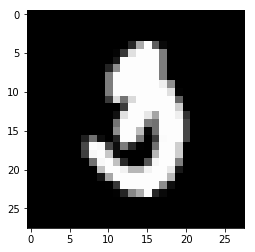

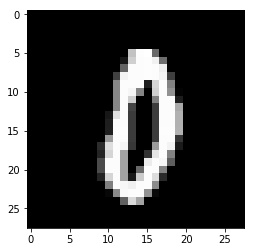

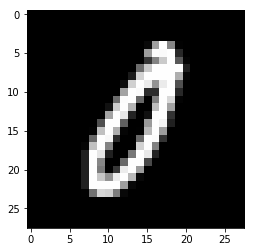

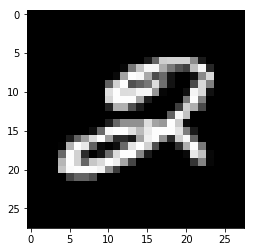

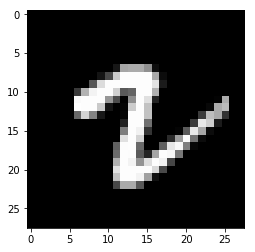

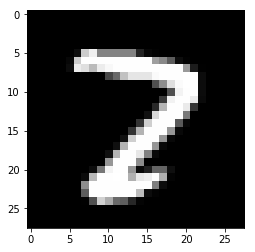

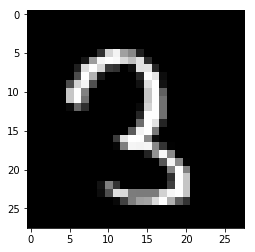

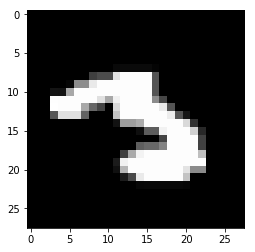

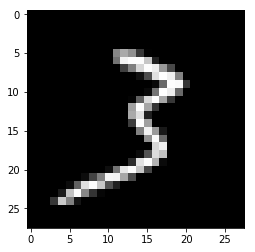

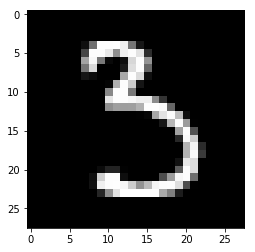

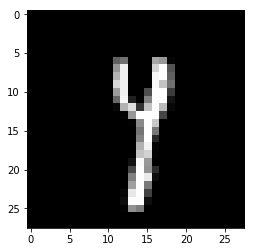

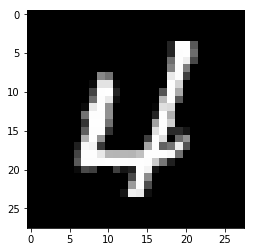

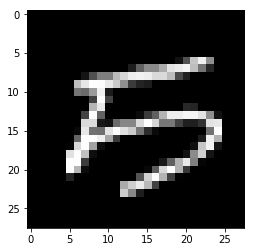

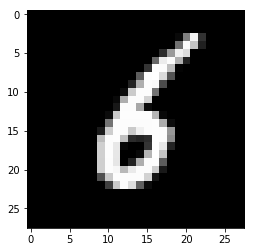

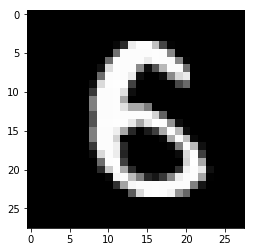

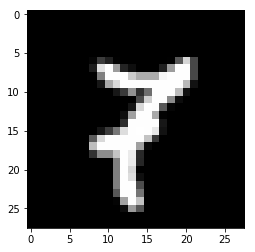

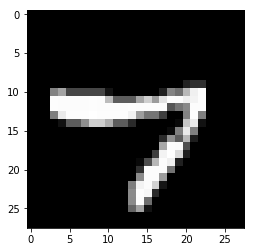

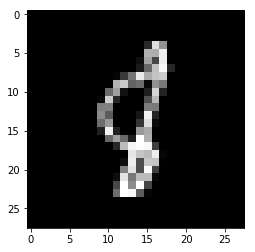

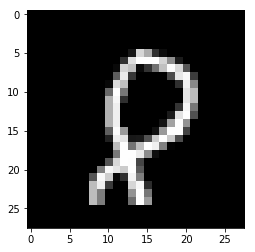

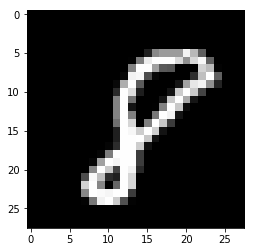

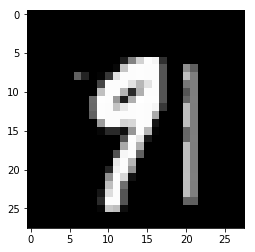

In [22]:
import matplotlib.pyplot as plt
% matplotlib inline

def show_sample(id):
    show_sample_img(train_images[id, :])
def show_sample_img(img):
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.show()
    
sup_inds = [374, 2507, 9755, 12953, 16507, 16873, 23474, 
            23909, 30280, 35070, 49603, 50106, 51171, 51726, 51805, 55205, 57251, 57296, 57779, 59154] + \
               [16644, 45576, 52886, 42140, 29201, 7767, 24, 134, 8464, 15022, 15715, 15602, 11030, 3898, 10195, 1454,
                3290, 5293, 5806, 274]
    
# from min var choice
sup_inds = [37921, 9924, 49041, 32926, 37926, 5828, 28492, 8045, 38408, 37118, 31717, 15108, 5602, 35482, 56292, 59653, 36834, 15450, 49529, 6839]

# lba with 7%
sup_inds = [31952, 24138, 39818, 501, 24589, 34532, 25954, 9924, 26338, 10716, 14062, 8853, 1940, 9251, 7767, 8196, 10044, 9348, 3204, 1127]

#lba with 15%
sup_inds = [9924, 34058, 53476, 15715, 6428, 33598, 33464, 41753, 21250, 26389, 12950, 12464, 3795, 6761, 5638, 3952, 8300, 5632, 1475, 1875]
print(len(sup_inds))
print(train_labels[sup_inds])
show_sample(11797)

for i in range(10):
    for ind in sup_inds:
        if train_labels[ind] == i:
            show_sample(ind)

In [ ]:
def softmax(x):
    maxes = np.amax(x, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(x - maxes)
    dist = e / np.sum(e, axis=1).reshape(maxes.shape[0], 1)
    return dist

def one_hot(a, depth):
    b = np.zeros((a.size, depth))
    b[np.arange(a.size), a] = 1
    return b


with tf.Session(graph=graph) as sess:
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    FLAGS.checkpoint_dir = '/tmp/'
    ckpt = tf.train.get_checkpoint_state(FLAGS.checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

        
    sup_imgs, sup_lbls = model.get_images(t_sup_images, t_sup_labels, 1, sess)

    sup_embs = model.calc_embedding(sup_imgs, model.test_emb)
    train_embs = model.calc_embedding(train_images[0:10000,:], model.test_emb)

    match_ab = np.dot(sup_embs, np.transpose(train_embs))
    p_ba = softmax(np.transpose(match_ab))
    
    pred_ids = np.dot(p_ba, one_hot(sup_lbls, depth=model.num_labels))
    print(pred_ids.shape)
    preds = np.argmax(pred_ids, axis=1)
    corrects = (preds == train_labels[0:10000])
    
    cor_p_ba = p_ba[corrects]
    wrong_p_ba = p_ba[1-corrects]
    
    max_cor_ba = np.max(cor_p_ba, axis=1)
    print('avg p_ab for correct class for correct samples', np.mean(max_cor_ba > 0.65))
    
    max_wrong_ba = np.max(wrong_p_ba, axis=1)
    print('avg p_ab for incorrect class for incorrect samples', np.mean(max_wrong_ba > 0.65))
    
    # distances to other unlabeled samples
    # not normalized
    p_bb = np.dot(train_embs, np.transpose(train_embs))
    
    #ignore faraway samples
    print('p', np.percentile(p_bb, 95))
    p_bb[p_bb < np.percentile(p_bb, 95)] = 0
    p_bb[p_bb > 1] = 1
    
    # calculate region confidence: sample confidence + confidence of close-by_samples
    sample_conf = np.var(p_ba, axis = 1)
    print(np.mean(sample_conf), np.max(sample_conf), np.min(sample_conf))
    thresh = 0.01
    sample_conf[sample_conf > thresh] = 4
    sample_conf[sample_conf < thresh] = -1
    region_conf = np.dot(p_bb, sample_conf)
    
    cor_rc = region_conf[corrects]
    wrong_rc = region_conf[1-corrects]
    
    
    #print('avg region confidence for correct samples', np.mean(cor_rc))
    
    #print('avg region confidence for incorrect samples', np.mean(wrong_rc))
    
    indices = np.argpartition(region_conf, kth=model.num_labels)[:model.num_labels]
    print('indices', indices)
    
    for i in indices:
        show_sample(i)
        print('ii', i, train_labels[i], region_conf[i], sum(p_bb[i, :]))

    #find close by samples and visualize them
    close_by_indices = np.where( p_bb[am, :] > 0 )
    for samp in close_by_indices[0]:
        show_sample(samp)
    
    for img in sup_imgs:
        show_sample_img(img)
    
    
    # now, calculate the 'confidence' of the region around the sample
    
    print(p_bb.shape)
    print('0',p_bb[0])
    print('45',p_bb[45])
    print(np.argmax(p_bb[0]), p_bb[0][1634])
    print(np.argmax(p_bb[45]), p_bb[45][8837], p_bb[45][45])
    
    print(np.mean(np.diag(p_bb)))
    
    print(p_ba[1634,:])
    print(p_ba[8837,:])
    print(train_labels[45], train_labels[8837])
    coord.request_stop()
    coord.join(threads)

In [5]:
with sess:
    test_pred = model.classify(test_images).argmax(-1)
    print (np.mean(test_pred == test_labels))

RuntimeError: Attempted to use a closed Session.